# Preliminaries

In [9]:
from dbfread import DBF
from gen_recover import *
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np

In [2]:
# normalized objectives by empirical stdevs
def experiment_histog(moments, stdevs, m):
    k = len(moments)
    from cvxopt import matrix, solvers
    solvers.options['show_progress'] = False
    A = np.zeros((m + 2 * k + 3, m + k + 1))
    B = np.zeros(m + 2 * k + 3)
    C = np.zeros(m + k + 1)
    # set C (optimization)
    for i in xrange(m + 1, m + k + 1):
        C[i] = 1.0
    # set B (constraints)
    B[0] = 1.0
    B[1] = -1.0
    for i in xrange(k):
        B[m + 3 + (2 * i)] = moments[i]
        B[m + 3 + (2 * i) + 1] = -1.0 * moments[i]
    # set A (linear coefficients)
    for i in xrange(m + 1):
        A[0][i] = 1.0
        A[1][i] = -1.0
        A[2 + i][i] = -1.0

    for j in xrange(k):
        A[m + 3 + (2 * j)][m + 1 + j] = -1.0
        A[m + 3 + (2 * j) + 1][m + 1 + j] = -1.0
        for i in xrange(m + 1):
            A[m + 3 + (2 * j)][i] = (((float(i) / float(m))) ** (j + 1))
            A[m + 3 + (2 * j) + 1][i] = (-1.0 * ((float(i) / float(m))) ** (j + 1))
    # print A
    G = matrix(np.ndarray.tolist(np.transpose(A)))
    h = matrix(np.ndarray.tolist(B))
    weights = np.zeros(m + k + 1)
    for i in xrange(k):
        weights[m + i + 1] = 1.0 / (stdevs[i] ** 2)
    P = matrix(np.ndarray.tolist(np.diag(weights)))
    q = matrix(np.ndarray.tolist(np.zeros(m + k + 1)))
    # print B
    # print C
    #sol = solvers.lp(matrix(np.ndarray.tolist(C)), matrix(np.ndarray.tolist(A)), matrix(np.ndarray.tolist(B)))
    sol = solvers.qp(P, q, G, h)
    #print np.dot(C, np.asarray(sol['x']))
    return sol['x']

In [3]:
def moments_stdevs(samples, k):
    n, s = samples.shape
    counts = np.sum(samples, axis=1)
    mom_dist = [np.asarray([float(comb(counts[j], i)) / float(comb(s, i)) for j in xrange(n)]) for i in xrange(1, k + 1)]
    moments = [np.mean(mom) for mom in mom_dist]
    stdevs = [np.std(mom) / math.sqrt(n) for mom in mom_dist]
    return moments, stdevs

def moments_stdevs_stacked(samples, k):
    moments = []
    stdevs = []
    for i in xrange(1, k + 1):
        mom_dist = np.asarray([float(comb(row[1], i)) / float(comb(row[0], i)) for row in samples if (row[0] >= i)])
        moments.append(np.mean(mom_dist))
        stdevs.append(np.std(mom_dist) / math.sqrt(len(mom_dist)))
    return moments, stdevs

def cdf(mesh):
    return np.cumsum(mesh)

def cdf_distro(sample_ps, granularity):
    ss = sorted(sample_ps)
    cdf = np.zeros(granularity + 1)
    for p in ss:
        cdf[int(p * granularity) + 1 : granularity + 1] += np.ones(granularity - int(p * granularity))
    cdf /= float(len(ss))
    return cdf

# Load data, 1976 - 2004

In [14]:
county_dict = {}

for i in xrange(7):
    year = 1976 + (4 * i)
    year_data = np.loadtxt("Elections/County/" + str(year) + "-" + str(year + 4) + "/ERBIG01" + str(chr(65 + i)) + ".CSV", skiprows=2, delimiter=',', dtype='str')
    for row in year_data:
        if row[0][1] == 'C':
            name = row[6].lower()[1:-1]
            state = row[4].lower()[1:-1]
            dwin = int(int(row[8]) > int(row[9]))
            if (name, state) in county_dict:
                county_dict[(name, state)] += np.asarray([1, dwin])
            else:
                county_dict[(name, state)] = np.asarray([1, dwin])

year_data = np.loadtxt("Elections/County/2000-2004/ERBIG01G.CSV", skiprows=2, delimiter=',', dtype='str')
for row in year_data:
    if row[0][1] == 'C':
        name = row[6].lower()[1:-1]
        state = row[4].lower()[1:-1]
        dwin = int(int(row[30]) > int(row[31]))
        if (name, state) in county_dict:
            county_dict[(name, state)] += np.asarray([1, dwin])
        else:
            county_dict[(name, state)] = np.asarray([1, dwin])
stacked_county_data = np.asarray([county_dict[key] for key in county_dict])

# Experiment

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


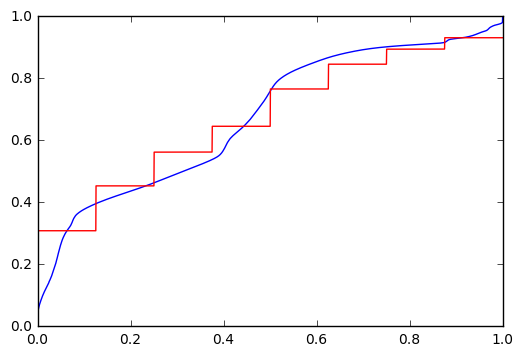

In [21]:
total_cdf = np.zeros((2001, 1))
n = len(stacked_county_data)
for i in xrange(20):
    print "iteration " + str(i)
    #subsample = stacked_county_data[np.random.randint(n, size=n/10)]
    #m, s = moments_stdevs_stacked(subsample, 8)
    m, s = moments_stdevs_stacked(stacked_county_data[i * (n / 20) : (i + 1) * (n / 20)], 8)
    nonzero = len(m)
    if 0.0 in m:
        nonzero = m.index(0.0)
    x = experiment_histog(m[:nonzero], s[:nonzero], 2000)
    total_cdf += np.asarray(x[:2001])
total_cdf /= 20.0
x_mesh = np.linspace(0, 1, 2001)
y_mesh = cdf(total_cdf)
empirical_ps = np.asarray([(float(row[1]) / float(row[0])) for row in stacked_county_data])
axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh, color='blue')
plt.plot(x_mesh, cdf_distro(empirical_ps, 2000), color='red')

In [7]:
stacked_county_data_big = np.asarray([big_county_dict[key] for key in big_county_dict])
m, s = moments_stdevs_stacked(stacked_county_data_big, 11)
x = experiment_histog(m, s, 2000)
x_mesh = np.linspace(0, 1, 2001)
#ss = stdevs(x_mesh, list(x[:2001]), 20)
"""
x = experiment_histog(m, ss, 2000)
ss = stdevs(x_mesh, list(x[:2001]), 20)
x = experiment_histog(m, ss, 2000)
ss = stdevs(x_mesh, list(x[:2001]), 20)
x = experiment_histog(m, ss, 2000)
ss = stdevs(x_mesh, list(x[:2001]), 20)
"""
#x = experiment_histog(m, ss, 2000)
y_mesh = cdf(x[:2001])
plt.plot(x_mesh, y_mesh)

NameError: name 'big_county_dict' is not defined